First, we want to do some exploratory data analysis ןn order to understand the problem.
We need the Pandas & Numpy libraries to read the data in and manipulate it, Seaborn & Matplotlib for visualization and Scipy for statistical tests. 

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

We read the data in:

In [2]:
os.chdir('C:\\Users\ordav\Desktop\kaggle')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


Start with looking at data:

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We seperate the predictors from the target variable "Survived"

In [5]:
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)

We can drop the PassangerId and Ticket columns which can not help us with prediction. We will save the passengerId column for later, it is part of the submission format.

In [6]:
X_train = X_train.drop(['PassengerId', 'Ticket'], axis = 1)
test_id = test['PassengerId']
test = test.drop(['PassengerId', 'Ticket'], axis = 1)

Looking for Null values

In [7]:
X_train.isna().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

We see that for the 'Cabin' feature, 687/891 entries are missing, this proportion is too large in order to fill with high enough certainty. It is better to discard this feature.

In [9]:
X_train = X_train.drop('Cabin', axis = 1)
test = test.drop('Cabin', axis = 1)

Lets have a look at the 'Embarked' column.

In [10]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Each passenger can get 1 of 3 values.
We will fill the missing values in the 'Embarked' column with its mode.

In [11]:
X_train['Embarked'] = X_train['Embarked'].fillna(X_train['Embarked'].mode()[0])

In order to fill missing value for 'Fare' in the test data, we will use the median fare of the class the passenger traveled in.

In [12]:
test['Pclass'][test['Fare'].isna()]

152    3
Name: Pclass, dtype: int64

In [13]:
test['Fare'] = test['Fare'].fillna(train[train['Pclass'] == 3]['Fare'].median())

Lets try and find a connection between the class and the probability of survival.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

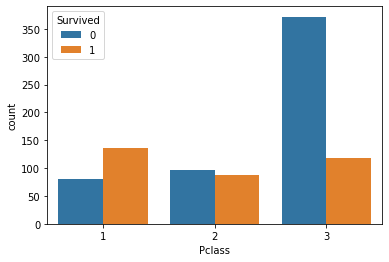

In [14]:
sns.countplot(data = train, x = 'Pclass', hue = 'Survived')

We can easily see that the proportion of passengers who survived decreases dramtically with the class. This seems to be an important feature. We Will use it as an ordinal variable, since the order of the classes seems significant.

We now turn our attention to the 'Sex' feature.

<AxesSubplot:xlabel='Sex', ylabel='count'>

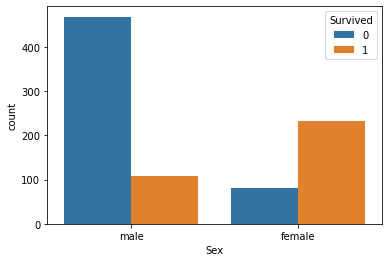

In [15]:
sns.countplot(data = train, x = 'Sex', hue = 'Survived')

Obviously, this feature tells us a lot about the chances a passenger survived. Women seem to survived in a much higher precentage than men did.
We turn this feature to an indicator that the passenger is female, and drop the 'Sex' column.

In [16]:
X_train['Female'] = pd.get_dummies(train['Sex'])['female']
test['Female'] = pd.get_dummies(test['Sex'])['female']
X_train.drop('Sex', axis = 1, inplace=True)
test.drop('Sex', axis = 1, inplace=True)

We now try to find out if the port the passenger embarked on its survival probability.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

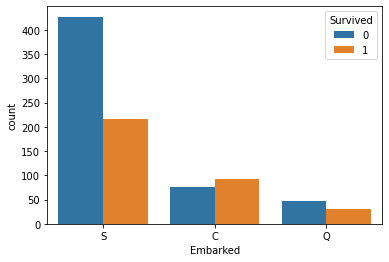

In [17]:
sns.countplot(data = train, hue = 'Survived', x = 'Embarked')

It looks like this might be helpful predictor of the survival chance, but lets try and see if this can actually be explained using a differnet feature.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

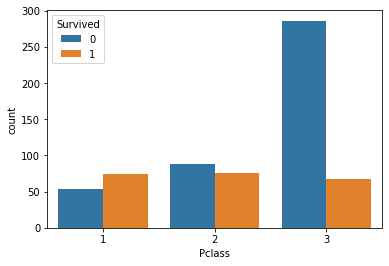

In [18]:
sns.countplot(data = train[train['Embarked'] == 'S'], hue = 'Survived', x = 'Pclass')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

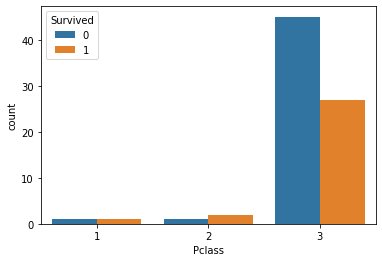

In [19]:
sns.countplot(data = train[train['Embarked'] == 'Q'], hue = 'Survived', x = 'Pclass')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

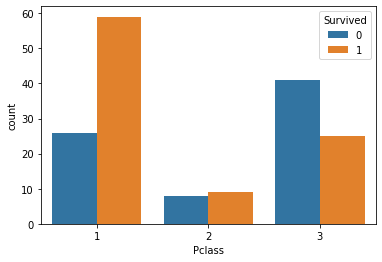

In [20]:
sns.countplot(data = train[train['Embarked'] == 'C'], hue = 'Survived', x = 'Pclass')

We will preform a Chi-Square test to try and find a dependence between the port and survival columns, in each seperate class.
Wh actually have 3 seperate hypothesis that we test, in each the null hypothesis us that inside class i 'the 'Embarked' and 'Survived' variables are independent.

In [21]:
from scipy.stats import chisquare

In [22]:
n_1_C_1 = len(train[(train['Embarked'] == 'C') & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_C_1 = len(train[(train['Embarked'] == 'C') & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
n_1_Q_1 = len(train[(train['Embarked'] == 'Q') & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_Q_1 = len(train[(train['Embarked'] == 'Q') & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
n_1_S_1 = len(train[(train['Embarked'] == 'S') & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_S_1 = len(train[(train['Embarked'] == 'S') & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 1st class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_C_1, n_0_Q_1, n_0_S_1], [n_1_C_1, n_1_Q_1, n_1_S_1]]))[1]))

p-value of the test to check dependence in the 1st class is: 0.2418598277637078


In [23]:
n_1_C_2 = len(train[(train['Embarked'] == 'C') & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_C_2 = len(train[(train['Embarked'] == 'C') & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)
n_1_Q_2 = len(train[(train['Embarked'] == 'Q') & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_Q_2 = len(train[(train['Embarked'] == 'Q') & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)
n_1_S_2 = len(train[(train['Embarked'] == 'S') & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_S_2 = len(train[(train['Embarked'] == 'S') & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 2nd class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_C_2, n_0_Q_2, n_0_S_2], [n_1_C_2, n_1_Q_2, n_1_S_2]]))[1]))

p-value of the test to check dependence in the 2nd class is: 0.6945854175115084


In [24]:
n_1_C_3 = len(train[(train['Embarked'] == 'C') & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_C_3 = len(train[(train['Embarked'] == 'C') & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)
n_1_Q_3 = len(train[(train['Embarked'] == 'Q') & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_Q_3 = len(train[(train['Embarked'] == 'Q') & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)
n_1_S_3 = len(train[(train['Embarked'] == 'S') & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_S_3 = len(train[(train['Embarked'] == 'S') & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 3rd class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_C_3, n_0_Q_3, n_0_S_3], [n_1_C_3, n_1_Q_3, n_1_S_3]]))[1]))

p-value of the test to check dependence in the 3rd class is: 7.873309289379242e-05


If we use Holm's method for multiple tests with a FWER of 0.05, we can only reject the 3rd null hypothesis and deduce a dependence only for passengers in the 3rd class. Therfore, we will create a new feature which will indicate the port the passenger embarked in, but only for passengers in the 3rd class. It will be ordinal, since we can see the difference in survvial rate between the different classes.

In [25]:
def third_class_ports(x,y):
    if x == 3:
        if y == 'C':
            return 1
        elif y == 'Q':
            return 2
        else:
            return 3
    else:
        return 0
    
X_train['Ports3rdClass'] = X_train.apply(lambda x : third_class_ports(x['Pclass'], x['Embarked']), axis = 1)
test['Ports3rdClass'] = test.apply(lambda x : third_class_ports(x['Pclass'], x['Embarked']), axis = 1)

X_train.drop('Embarked', axis = 1, inplace = True)
test.drop('Embarked', axis = 1, inplace = True)

We try and understand if we can understand useful data from the name column.

In [26]:
train['title'] = train['Name'].apply(lambda x: x.split()[1])

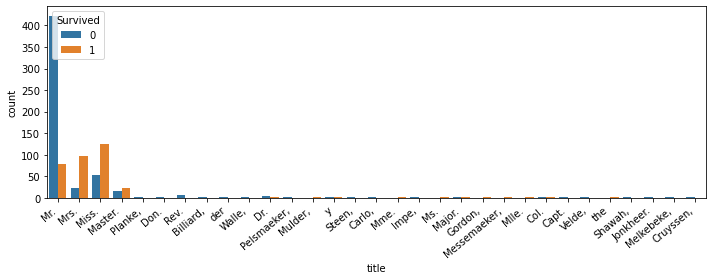

In [27]:
plt.figure(figsize=(10,4))

ax = sns.countplot(data = train, x = 'title', hue = 'Survived')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We see that there are 3 dominant classes for the passenger's title. The only significant insight I can see is that married women had a higher survival rate than not married ones, but this will actually be shown using the 'Parch', 'SibSp' & 'Age' features that we will explore later on. Therefore, we will discard this column.

In [29]:
X_train.drop(['Name', 'Title'], axis=1, inplace=True)
test.drop(['Name', 'Title'], axis=1, inplace=True)

In [30]:
test

,Pclass,Age,SibSp,Parch,Fare,Female,Ports3rdClass,MrMaster,MrsMiss
0,3,34.5,0,0,7.8292,0,2,0,0
1,3,47.0,1,0,7.0000,1,3,0,1
2,2,62.0,0,0,9.6875,0,0,0,0
3,3,27.0,0,0,8.6625,0,3,0,0
4,3,22.0,1,1,12.2875,1,3,0,1
...,...,...,...,...,...,...,...,...,...
413,3,NaN,0,0,8.0500,0,3,0,0
414,1,39.0,0,0,108.9000,1,0,0,0
415,3,38.5,0,0,7.2500,0,3,0,0
416,3,NaN,0,0,8.0500,0,3,0,0


Lets look for a conection between the passenger's age and the probability they survived.

<AxesSubplot:xlabel='Survived', ylabel='Age'>

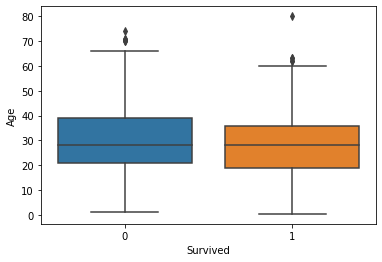

In [31]:
sns.boxplot(data = train, x = 'Survived', y = 'Age')

At first glance, there seems to be only a weak connection between the variables, but lets take a closer look by dividing our data to different age groups. 
We create a new column that classifies the passenger to a certain age group. We than look at the survival rate for each group seperately.

In [32]:
train_with_age = train.loc[~train['Age'].isna(), :]

def Age_Group(x):
    if x < 14:
        return 'Kid'
    elif x >= 14 and x < 30:
        return 'Young Adult'
    elif x >= 30 and x < 50:
        return 'Adult'
    else: 
        return 'Elderly'
    
train.loc[~train['Age'].isna(), 'AgeGroup'] = train_with_age['Age'].apply(Age_Group)

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

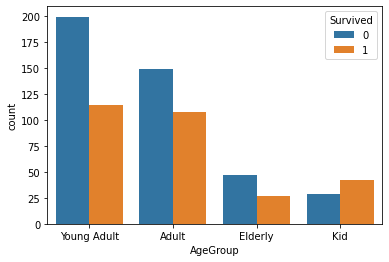

In [33]:
sns.countplot(data = train.loc[~train['Age'].isna(), :], x = 'AgeGroup', hue = 'Survived')

We can see that indeed the age group a passenger belongs to is relevant to their survival probability. "Kids" in the training set survived with a rate higher than 0.5, but only about 1/3 of the "young adults" survived.
We will create a new column that will treat the age group as an ordinal variable, higher values will correspond to age groups with a higher survival rate. But, in order to do that, we first need to impute the missing values in this column. We will do so using the iterative imputer in scikit-learn. It uses bayesian ridge regression using the other columns for the imputation.


In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=1000, max_value=80, min_value=1)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
test = pd.DataFrame(imputer.transform(test), columns = test.columns)

In [35]:
def Age_Group_2(x):
    if x < 14:
        return 3
    elif x >= 14 and x < 30:
        return 1
    elif x >= 30 and x < 50:
        return 2
    else: 
        return 0

train['AgeGroup'] = train['Age'].apply(Age_Group)
X_train['AgeGroup'] = X_train['Age'].apply(Age_Group_2)
test['AgeGroup'] = test['Age'].apply(Age_Group_2)
X_train = X_train.drop('Age', axis = 1)
test = test.drop('Age', axis = 1)

The "SibSp" feature tells us how many siblings and spouses a passenger had. We try and visualize its connection the target variable in two ways.

<AxesSubplot:xlabel='Survived', ylabel='SibSp'>

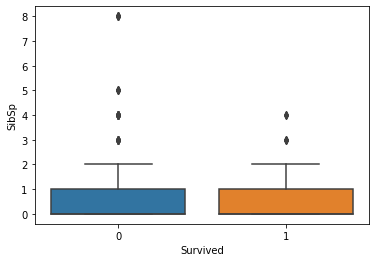

In [36]:
sns.boxplot(data = train, x = 'Survived', y = 'SibSp')

This does not tell us much, but what if we look at the appropriate countplot:

<AxesSubplot:xlabel='SibSp', ylabel='count'>

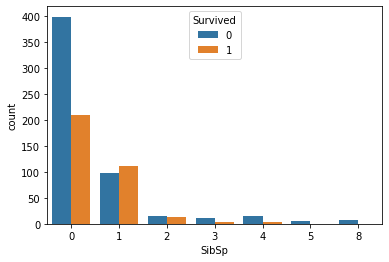

In [37]:
sns.countplot(data = train, hue = 'Survived', x = 'SibSp')

First thing we can notice is that almost all of our observations have at most 1 siblings and spouses on the ship.
Second, the survival rate of passengers with 1 or 2 siblings and spouses is around 0.5, which is nuch higher than in other groups. 
Lets look at the class distribution for people with different 'SibSp' variable. 

<AxesSubplot:xlabel='Pclass', ylabel='count'>

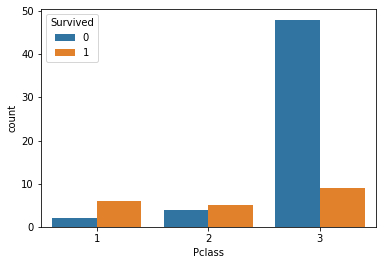

In [38]:
sns.countplot(data = train[(train['SibSp'] > 1)], x = 'Pclass', hue = 'Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

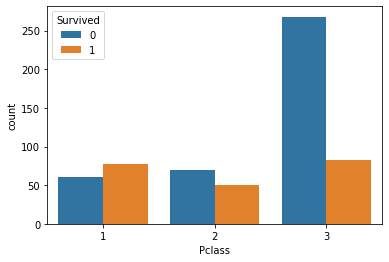

In [39]:
sns.countplot(data = train[(train['SibSp'] == 0)], x = 'Pclass', hue = 'Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

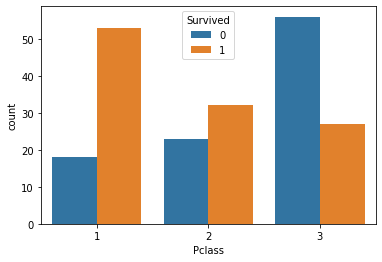

In [40]:
sns.countplot(data = train[(train['SibSp'] == 1)], x = 'Pclass', hue = 'Survived')

Lets try and do the same analysis as we did for the 'Embarked' feature and check the dependence between 'SibSp' and 'Survived' inside each seperate class.

In [41]:
def SibSp(x):
    if x == 0:
        return 0
    elif x == 1: 
        return 1
    else:
        return 2


train['SibSp'] = train['SibSp'].apply(SibSp)

In [42]:
n_1_0_3 = len(train[(train['SibSp'] == 0) & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_0_3 = len(train[(train['SibSp'] == 0) & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)
n_1_1_3 = len(train[(train['SibSp'] == 1) & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_1_3 = len(train[(train['SibSp'] == 1) & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)
n_1_2_3 = len(train[(train['SibSp'] == 2) & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_2_3 = len(train[(train['SibSp'] == 2) & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 3rd class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_0_3, n_0_1_3, n_0_2_3], [n_1_0_3, n_1_1_3, n_1_2_3]]))[1]))

p-value of the test to check dependence in the 3rd class is: 0.06752442347539821


In [43]:
n_1_0_2 = len(train[(train['SibSp'] == 0) & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_0_2 = len(train[(train['SibSp'] == 0) & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)
n_1_1_2 = len(train[(train['SibSp'] == 1) & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_1_2 = len(train[(train['SibSp'] == 1) & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)
n_1_2_2 = len(train[(train['SibSp'] == 2) & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_2_2 = len(train[(train['SibSp'] == 2) & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 2nd class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_0_2, n_0_1_2, n_0_2_2], [n_1_0_2, n_1_1_2, n_1_2_2]]))[1]))

p-value of the test to check dependence in the 2nd class is: 0.11154522975614072


In [44]:
n_1_0_1 = len(train[(train['SibSp'] == 0) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_0_1 = len(train[(train['SibSp'] == 0) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
n_1_1_1 = len(train[(train['SibSp'] == 1) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_1_1 = len(train[(train['SibSp'] == 1) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
n_1_2_1 = len(train[(train['SibSp'] == 2) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_2_1 = len(train[(train['SibSp'] == 2) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 1st class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_0_1, n_0_1_1, n_0_2_1], [n_1_0_1, n_1_1_1, n_1_2_1]]))[1]))

p-value of the test to check dependence in the 1st class is: 0.025505814378072537


If we use Holm's method for multiple tests with a FWER of 0.05, we can only reject the 3rd null hypothesis and deduce a dependence only for passengers in the 1st class. Therfore, we will create a new feature which will indicate if the passenger had 0,1 or more than 1 siblings and spouses on board, but only for passengers in the 1st class. 
Lets see what should its values be:

In [45]:
print('Survival rate for "SibSp" = 0 in the 1st class: ' + str(n_1_0_1 / (n_1_0_1 + n_0_0_1)))

Survival rate for "SibSp" = 0 in the 1st class: 0.5620437956204379


In [46]:
print('Survival rate for "SibSp" = 1 in the 1st class: ' + str(n_1_1_1 / (n_1_1_1 + n_0_1_1)))

Survival rate for "SibSp" = 1 in the 1st class: 0.7464788732394366


In [47]:
print('Survival rate for "SibSp" > 1 in the 1st class: ' + str(n_1_2_1 / (n_1_2_1 + n_0_2_1)))

Survival rate for "SibSp" > 1 in the 1st class: 0.75


We will therefore give a value of 1 if "SibSp" = 0, and 2 if it is larger than 0.

In [48]:
def first_class_sibsp(x,y):
    if x == 1:
        if y == 0:
            return 1
        else:
            return 2
    else:
        return 0
    
X_train['SibSp1stClass'] = X_train.apply(lambda x : first_class_sibsp(x['Pclass'], x['SibSp']), axis = 1)
test['SibSp1stClass'] = test.apply(lambda x : first_class_sibsp(x['Pclass'], x['SibSp']), axis = 1)

X_train.drop('SibSp', axis = 1, inplace = True)
test.drop('SibSp', axis = 1, inplace = True)

We can try to preform a similar analysis to the 'Parch' feature, which tells us how many parents and children a passenger had with hom on the ship.

<AxesSubplot:xlabel='Parch', ylabel='count'>

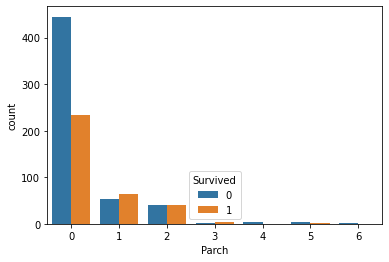

In [49]:
sns.countplot(data = train, hue = 'Survived', x = 'Parch')

We can see that people with no parents and children on board survived at a much lower rate than those with one or more.
Lets have a look at the age group of people with 0 on the 'Parch' column.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

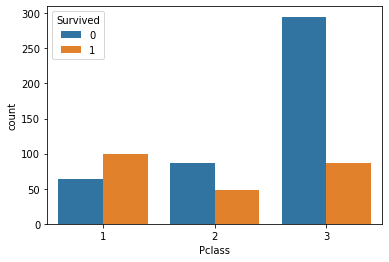

In [50]:
sns.countplot(data = train[(train['Parch'] == 0)], x = 'Pclass', hue = 'Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

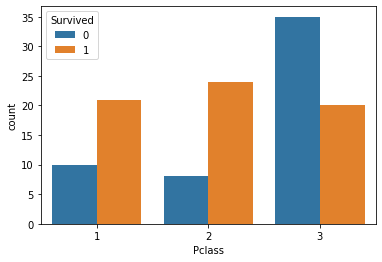

In [51]:
sns.countplot(data = train[(train['Parch'] == 1)], x = 'Pclass', hue = 'Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

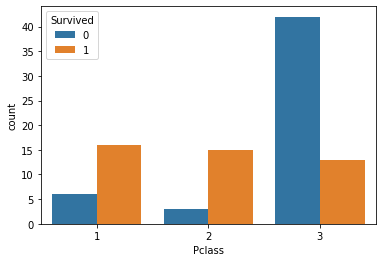

In [52]:
sns.countplot(data = train[(train['Parch'] > 1)], x = 'Pclass', hue = 'Survived')

In [53]:
def Parch(x):
    if x == 0:
        return 0
    elif x == 1: 
        return 1
    else:
        return 2


train['Parch'] = train['Parch'].apply(Parch)

In [54]:
n_1_0_3 = len(train[(train['Parch'] == 0) & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_0_3 = len(train[(train['Parch'] == 0) & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)
n_1_1_3 = len(train[(train['Parch'] == 1) & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_1_3 = len(train[(train['Parch'] == 1) & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)
n_1_2_3 = len(train[(train['Parch'] == 2) & (train['Pclass'] == 3) & (train['Survived'] == 1)].index)
n_0_2_3 = len(train[(train['Parch'] == 2) & (train['Pclass'] == 3) & (train['Survived'] == 0)].index)


print('p-value of the test to check dependence in the 3rd class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_0_3, n_0_1_3, n_0_2_3], [n_1_0_3, n_1_1_3, n_1_2_3]]))[1]))

p-value of the test to check dependence in the 3rd class is: 0.08247195235459456


In [55]:
n_1_0_2 = len(train[(train['Parch'] == 0) & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_0_2 = len(train[(train['Parch'] == 0) & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)
n_1_1_2 = len(train[(train['Parch'] == 1) & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_1_2 = len(train[(train['Parch'] == 1) & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)
n_1_2_2 = len(train[(train['Parch'] == 2) & (train['Pclass'] == 2) & (train['Survived'] == 1)].index)
n_0_2_2 = len(train[(train['Parch'] == 2) & (train['Pclass'] == 2) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 2nd class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_0_2, n_0_1_2, n_0_2_2], [n_1_0_2, n_1_1_2, n_1_2_2]]))[1]))

p-value of the test to check dependence in the 2nd class is: 1.935438126129281e-06


In [56]:
n_1_0_1 = len(train[(train['Parch'] == 0) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_0_1 = len(train[(train['Parch'] == 0) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
n_1_1_1 = len(train[(train['Parch'] == 1) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_1_1 = len(train[(train['Parch'] == 1) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
n_1_2_1 = len(train[(train['Parch'] == 2) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
n_0_2_1 = len(train[(train['Parch'] == 2) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)

print('p-value of the test to check dependence in the 1st class is: ' + 
      str(chi2_contingency(observed=np.array([[n_0_0_1, n_0_1_1, n_0_2_1], [n_1_0_1, n_1_1_1, n_1_2_1]]))[1]))

p-value of the test to check dependence in the 1st class is: 0.4607820537216153


We can only infer dependence inside the 2nd class. We will create a similar column to the one we created to replace 'SibSp'.

In [57]:
def second_class_parch(x,y):
    if x == 2:
        if y == 0:
            return 1
        elif y == 1:
            return 2
        else:
            return 3
    else:
        return 0
    
X_train['Parch2ndClass'] = X_train.apply(lambda x : second_class_parch(x['Pclass'], x['Parch']), axis = 1)
test['Parch2ndClass'] = test.apply(lambda x : second_class_parch(x['Pclass'], x['Parch']), axis = 1)

X_train.drop('Parch', axis = 1, inplace = True)
test.drop('Parch', axis = 1, inplace = True)

We want to explore how the 'Fare' and survival rate are connected.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

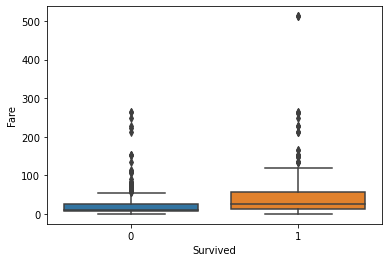

In [58]:
sns.boxplot(data = train, y = 'Fare', x = 'Survived')

Not surprisingly, the 'Fare' passengers paid in the survivors group tends to be higher. But, as we saw before, we might be able to explain that better using the passenger's class.
We'll explore it further.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

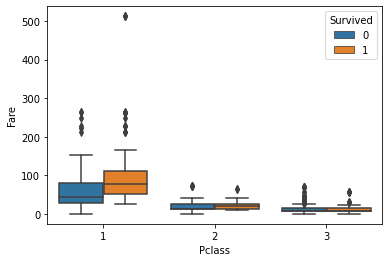

In [59]:
sns.boxplot(data = train, y = 'Fare', x = 'Pclass', hue = 'Survived')

We can see that in the 2nd and 3rd classes, paying more does not seem to buy you a higher survival rate. On the other hand, in the 1st class it does. We will create a new column that will be equivalent to 4 classes. The highest class will be for people who payed more than t in the 1st class.
We try to find the best t value, using a Chi-Square test.

In [60]:
def p_value(t):
    n_1_o_1 = len(train[(train['Fare'] > t) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
    n_1_o_0 = len(train[(train['Fare'] > t) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
    n_1_u_1 = len(train[(train['Fare'] <= t) & (train['Pclass'] == 1) & (train['Survived'] == 1)].index)
    n_1_u_0 = len(train[(train['Fare'] <= t) & (train['Pclass'] == 1) & (train['Survived'] == 0)].index)
    return chi2_contingency(observed=np.array([[n_1_o_0, n_1_o_1], [n_1_u_0, n_1_u_1]]))[1]

p_values = []
m = min(train.loc[train.Pclass == 1, :]['Fare'])
M = max(train.loc[train.Pclass == 1, :]['Fare'])

for t in range(int(m)+1, int(M)):
    p_values.append(p_value(t))

In [61]:
np.argmin(p_values)

51

In [62]:
def Class(x, y):
    t = int(m) + 1 + 51
    if x == 1:
        if y > t:
            return 0
        else:
            return 1
    else:
        return x
    
X_train['Class'] = X_train.apply(lambda x : Class(x['Pclass'], x['Fare']), axis = 1)
test['Class'] = test.apply(lambda x : Class(x['Pclass'], x['Fare']), axis = 1)

X_train.drop(['Fare', 'Pclass'], axis = 1, inplace = True)
test.drop(['Fare', 'Pclass'], axis = 1, inplace = True)

We have now filled all the missing data, and finishing our data analysis.
Last thing we are going to do before moving to our model selection part, we will scale the data. It is important because we will use regularization in our models.

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
test = pd.DataFrame(scaler.transform(test), columns = test.columns)

Lets have a look at the proccessed data

In [64]:
X_train

,Female,Ports3rdClass,MrMaster,MrsMiss,AgeGroup,SibSp1stClass,Parch2ndClass,Class
0,0.000000,2.156936,0.0,0.000000,1.283840,0.00000,0.000000,2.741759
1,2.093269,0.000000,0.0,2.919037,2.567681,3.16704,0.000000,0.000000
2,2.093269,2.156936,0.0,0.000000,1.283840,0.00000,0.000000,2.741759
3,2.093269,0.000000,0.0,2.919037,2.567681,3.16704,0.000000,0.000000
4,0.000000,2.156936,0.0,0.000000,2.567681,0.00000,0.000000,2.741759
...,...,...,...,...,...,...,...,...
886,0.000000,0.000000,0.0,0.000000,1.283840,0.00000,1.589349,1.827839
887,2.093269,0.000000,0.0,0.000000,1.283840,1.58352,0.000000,0.913920
888,2.093269,2.156936,0.0,0.000000,1.283840,0.00000,0.000000,2.741759
889,0.000000,0.000000,0.0,0.000000,1.283840,1.58352,0.000000,0.913920


In order to choose our prediction algorithm, we will use a 10-Fold cross-validation. The parameters for each model will be chosen through an independent 5-Fold cross validation.

Starting with simpleset model: K-Nearest neighbors.

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':[1,5,7,10,12, 15, 20, 50], 'p' : [1,2], 'weights' : ['uniform', 'distance']}
knn = KNeighborsClassifier()
gridSearch = GridSearchCV(estimator=knn, param_grid=param_grid, cv = 5)
gridSearch.fit(X_train, y_train)
print('Optimal number of neighbors: ' + str(gridSearch.best_params_['n_neighbors']) + '\n' +
                                           'Optimal p-metric: ' + str(gridSearch.best_params_['p']) + '\n' +
                                           'Optimal weights strategy: ' + str(gridSearch.best_params_['weights']))

Optimal number of neighbors: 10
Optimal p-metric: 1
Optimal weights strategy: distance


In [66]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = gridSearch.best_params_['n_neighbors'],
                          p = gridSearch.best_params_['p'], weights = gridSearch.best_params_['weights'])
cross_val_scores = cross_val_score(knn, X = X_train, y = y_train, scoring='accuracy', cv = 10)
print('Mean cv score: ' + str(np.mean(cross_val_scores)) + 
      '\n Std cv score: ' + str(np.std(cross_val_scores)))

Mean cv score: 0.8316978776529338
 Std cv score: 0.0330175039028089


Now we will move to a parametric approach. Logistic regression with elastic-net penalty on the coefficients size.

In [67]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty='elasticnet', solver = 'saga')
paramGrid = {'C' : [0.001 * i for i in range(1,100)], 'l1_ratio' : [0, 0.25, 0.5, 0.75, 1]}
gridSearch = GridSearchCV(estimator=log_reg, cv=5, param_grid = paramGrid, scoring = 'accuracy')
gridSearch.fit(X_train, y_train)
print('Inverse regularization coefficient: ' + str(gridSearch.best_params_['C']) + '\n' + 
        'Optimal L1 Ratio: ' + str(gridSearch.best_params_['l1_ratio']))

Inverse regularization coefficient: 0.041
Optimal L1 Ratio: 0.25


computing the cross validation score on an independent folds division

In [68]:
log_reg = LogisticRegression(C=gridSearch.best_params_['C'], l1_ratio = gridSearch.best_params_['l1_ratio'], 
                             penalty = 'elasticnet', solver = 'saga')
cross_val_scores = cross_val_score(log_reg, X = X_train, y = y_train, scoring='accuracy', cv = 10)
print('Mean cv score: ' + str(np.mean(cross_val_scores)) + 
      '\n Std cv score: ' + str(np.std(cross_val_scores)))

Mean cv score: 0.8170786516853932
 Std cv score: 0.037511265824476996


KNN gave us a better score than logistic regression, which might imply that the seperation of the 2 classes is not close to linear.


Now trying SVM with a radial kernel. We will adjust both the C and gamma using 5-Fold CV. We will also give it a head start by telling it the proportion of people survived in the training set. It has a Bayesian interpertation as a prior distribution on Y.

In [69]:
from sklearn.svm import SVC

prop0 = sum(y_train == 0)/len(y_train)
prop1 = 1 - prop0
param_grid = {'C' : [0.5 * i for i in range(1,50)], 'gamma' : [0.01 * i for i in range(1,10)]}
svm = SVC(kernel = 'rbf', class_weight={0: prop0, 1:prop1})
gridSearch = GridSearchCV(estimator=svm, param_grid=param_grid, scoring = 'accuracy', cv = 5)
gridSearch.fit(X_train, y_train)
print('Optimal C: ' + str(gridSearch.best_params_['C']) + '\n' +
                                           'Optimal gamma: ' + str(gridSearch.best_params_['gamma']))

Optimal C: 15.5
Optimal gamma: 0.07


Calculating the CV score

In [70]:
svm = SVC(kernel='rbf', C = gridSearch.best_params_['C'], gamma = gridSearch.best_params_['gamma'], 
          class_weight={0: prop0, 1:prop1}, probability=True)
cross_val_scores = cross_val_score(svm, X = X_train, y = y_train, scoring='accuracy', cv = 10)
print('Mean cv score: ' + str(np.mean(cross_val_scores)) + 
      '\n Std cv score: ' + str(np.std(cross_val_scores)))

Mean cv score: 0.8125967540574282
 Std cv score: 0.02541636613913802


Moving to tree based methods, starting with AdaBoost. We will try different combinations of the number of trees, learning rate and the tree depth we are using for each tree in the ensemble.

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {'n_estimators':[500, 1000, 1500], 'learning_rate':[0.001 * i for i in range(1,4)],
             'base_estimator' : [DecisionTreeClassifier(criterion='entropy', max_depth=1),
                                 DecisionTreeClassifier(criterion='entropy', max_depth=2),
                                 DecisionTreeClassifier(criterion='entropy', max_depth=3)]}
Ada = AdaBoostClassifier()
gridSearch = GridSearchCV(estimator=Ada, param_grid=param_grid, cv= 5, scoring = 'accuracy')
gridSearch.fit(X_train, y_train)
print('Optimal number of estimators: ' + str(gridSearch.best_params_['n_estimators']) + '\n' +
                                           'Optimal learning rate: ' + str(gridSearch.best_params_['learning_rate']) + '\n' +
                                           'Optimal tree depth: ' + str(gridSearch.best_params_['base_estimator']))

Optimal number of estimators: 1500
Optimal learning rate: 0.002
Optimal tree depth: DecisionTreeClassifier(criterion='entropy', max_depth=2)


In [72]:
Ada = AdaBoostClassifier(n_estimators = gridSearch.best_params_['n_estimators'],
                                     learning_rate = gridSearch.best_params_['learning_rate'],
                                     base_estimator = gridSearch.best_params_['base_estimator'])
cross_val_scores = cross_val_score(Ada, X = X_train, y = y_train, scoring='accuracy', cv = 10)
print('Mean cv score: ' + str(np.mean(cross_val_scores)) + 
      '\n Std cv score: ' + str(np.std(cross_val_scores)))

Mean cv score: 0.8271535580524345
 Std cv score: 0.0338122603137303


Now trying random forest. we will tune the number of trees, number of features we decide from in each split, and the alpha, which decides how much do we prune the trees in the forest. We use entropy as our split criterion because it is more accurate than the gini index. 

In [73]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators':[300,500,1000], 'max_features':[2,3], 'ccp_alpha' : [0.005 * i for i in range(6)]}
randomForest = RandomForestClassifier(criterion = 'entropy')
gridSearch = GridSearchCV(estimator=randomForest, param_grid=param_grid, cv = 5, scoring = 'accuracy')
gridSearch.fit(X_train, y_train)
print('Optimal number of trees: ' + str(gridSearch.best_params_['n_estimators']) + '\n' +
                                           'Optimal number of features in each split: ' + 
                                              str(gridSearch.best_params_['max_features']) + '\n' +
                                           'Optimal alpha: ' + str(gridSearch.best_params_['ccp_alpha']))

Optimal number of trees: 1000
Optimal number of features in each split: 2
Optimal alpha: 0.0


In [74]:
randomForest = RandomForestClassifier(n_estimators = gridSearch.best_params_['n_estimators'], criterion = 'entropy',
                                     max_features = gridSearch.best_params_['max_features'],
                                     ccp_alpha = gridSearch.best_params_['ccp_alpha'])
cross_val_scores = cross_val_score(randomForest, X = X_train, y = y_train, scoring='accuracy', cv = 10)
print('Mean cv score: ' + str(np.mean(cross_val_scores)) + 
      '\n Std cv score: ' + str(np.std(cross_val_scores)))

Mean cv score: 0.8249687890137329
 Std cv score: 0.03342368766640164


Now we try XGBoost. Since the implementation is from another library, we will use its own cv function.

In [75]:
import xgboost as xgb

In [76]:
Dmatrix = xgb.DMatrix(data = X_train, label = y_train)
eta = [(0.005 * i) for i in range (1,6)]
max_depth = [3,4,5]
reg_lambda = [(0.1 * i) for i in range(15)]
best_score = 100
best3 = [0,0,0]
for e in eta:
    for m in max_depth:
        for l in reg_lambda:
            param_grid = {'eta' : e, 'max_depth' : m, 
                'reg_lambda' : l, 'objective' : 'binary:logistic', 'base_score' : prop1}
            xgb_cv = xgb.cv(params = param_grid, dtrain = Dmatrix, num_boost_round = 1000, nfold = 5, 
                   early_stopping_rounds = 5)
            if xgb_cv.iloc[-1 ,2] < best_score:
                best_score = xgb_cv.iloc[-1 ,2]
                best3 = [e,m,l]
                



In [77]:
best3

[0.02, 3, 1.4000000000000001]

In [78]:
xgb1 = xgb.XGBClassifier(n_estimators = 1000, eta = best3[0],
                                     max_depth = best3[1],  
                                      reg_lambda =  best3[2],
                                        objective='binary:logistic', grow_policy = 'lossguide',
                                        base_score = prop1)
cross_val_scores = cross_val_score(xgb1, X = X_train, y = y_train, scoring='accuracy', cv = 10)
print('Mean cv score: ' + str(np.mean(cross_val_scores)) +
      '\n Std cv score: ' + str(np.std(cross_val_scores)))

Mean cv score: 0.8238077403245943
 Std cv score: 0.03617227223477172


We got the best cv score using XGBoost.
Lets try submitting its predictions.
We use early stopping after 10 rounds without improvement in order to avoid overfitting.

In [79]:
from sklearn. model_selection import train_test_split

xgb1 = xgb.XGBClassifier(n_estimators = 1000, eta = best3[0],
                                     max_depth = best3[1],  
                                      reg_lambda =  best3[2],
                                        objective='binary:logistic', grow_policy = 'lossguide',
                                        base_score = prop1, early_stopping_rounds = 10)
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.1)
xgb1.fit(X_train_1, y_train_1, eval_set = [(X_val, y_val)], verbose = 0)
y_pred = xgb1.predict(test)
y_pred = pd.DataFrame({'PassengerId' : test_id, 'Survived' : y_pred})
y_pred.to_csv('SurvivalPredictionsXGB.csv', index = False)

We got 78.7% accuracy rate.